# Advanced Machine Learning - Project 2
## Mountain Car Problem with Reinforcement Learning

- Eduardo Carneiro - 62515
- Til Dietrich - 62928

## Notebook set-up


- Reverb Package does not work on Windows. Thus, we ran the notebook in Google Colab
- The next commands install all the necessary packages

In [27]:
# Uncomment to install packages in collab or if necessary
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet
!pip install gymnasium
!pip install seaborn

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-6).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.5).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [28]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import seaborn as sns
from tqdm import tqdm

import pyvirtualdisplay
import PIL

# Reverb is only necessary for the Deep Learning Part
# If commented, it is possible to run the Q-Learning locally
import reverb

import base64
import imageio
import IPython


import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [29]:
sns.set(style='whitegrid', palette='muted', context='paper')

## Table of Contents
### 1. The environment

### 2. Q-Learning
#### 2.1 Discetizing the observation space
#### 2.2 Baseline agent
#### 2.3 Hyperparameters
#### 2.4 Train the final agent

### 3. Deep-Q Learning
#### 3.1 Experiments
#### 3.2 Analysis
#### 3.3 Comparison

## 1. The environment

In [30]:
# Load environment
env = gym.make("MountainCar-v0",render_mode='rgb_array')

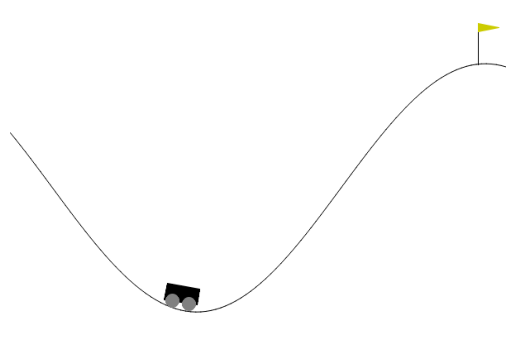

In [31]:
env.reset()
plt.imshow(env.render())
plt.axis('off')
plt.show()

In [32]:
# Confirm observation and action space dimensions
# Link to documentation: https://gymnasium.farama.org/environments/classic_control/mountain_car/
print(env.observation_space, env.action_space)

Box([-1.2  -0.07], [0.6  0.07], (2,), float32) Discrete(3)


The current state is always defined by the two parameters position (p) and velocity (v).

The action space is:
- 0: Accelerate to the left
- 1: Don’t accelerate
- 2: Accelerate to the right

## 1. Q-Learning

First, we define all necessary functions for better readibility

This first function discretizes the continuous state into a specified number of batches (or % of observations per batch).

In [33]:
# Function for discretizing the observation space, either by number of batches or by batch size
def discretize(interval, number_batches=-1, batch_percentage=0.1):

    sum = abs(interval[0]) + abs(interval[1])

    if number_batches != -1:
        batch_size = sum / number_batches
    else:
        batch_size = batch_percentage * sum

    return np.arange(interval[0], interval[1], batch_size)

These two functions assign the two values that define a space to one of the discretizes batches. We need two as the state is always defined by both position and velocity.

In [34]:
# Define functions for getting index of a batch (position and velocity)
def get_index_position_batch(position, position_batches):

    l = len(position_batches)

    for low in range(l):

        if position < position_batches[low]:
            return low-1

    return l-1

def get_index_velocity_batch(velocity, velocity_batches):

    l = len(velocity_batches)

    for low in range(l):

        if velocity < velocity_batches[low]:
            return low-1

    return l-1

This is a standard epsilon greedy function, which chooses a random action with probability epsilon and takes the greedy action otherwise.

In [35]:
# Define epsilon greedy function
def epsilon_greedy(state, epsilon):
    global q_table

    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        # Assuming state is a tuple with (position, velocity)
        return np.argmax(q_table[state[0], state[1], :])

This q-learning function is the key of the q-table based reinforcement learning.

First, it initializes a q-table with zeros with the dimension of the two state-definining variables (discretized) and the number of possible discrete actions (3 in this case). Furthermore, it initializes the lists to save the rewards, the number of steps taken in an episode, and whether the agent reached the flag in this episode.

Second, the outer loop (which is run as many times as we define episodes) initializes the state from the environment, and sets the total reward and steps to zero. Furthermore, it discretizes the extracted state from the environment, using our above-defined functions. 

Third, the inner loop performs the steps within each episode. First, an action is chosen, using the epsilon greedy function with a predefined epsilon. Next, the next state (state dash) and reward of taking that action are extracted. This state dash is discretized and the optimal action a dash, given that state dash extracted from the q-table. Then, the q-table is updated using the q-learning function as defined in class. In a next step, the step dash is set as the new current state, the rewards are added and the steps are incremented by one. If this step caused the agent to reach the flag, the inner loop is existed and the total rewards, and number of steps taken are recorded. 

Finally, the function returns the final optimal q-table, the list of total rewards (per episode) and a list of how many steps each episode took (irrespective of whether it ended in success or not).

In [36]:
# Define function for q-learning
def run_q_learning(env, alpha, gamma, epsilon, num_episodes, num_steps, position_batches, velocity_batches):
    global q_table
    q_table = np.zeros((len(position_batches), len(velocity_batches), env.action_space.n))
    arr_total_rewards = []
    arr_steps = []
    arr_done = np.zeros(num_episodes)

    for i in range(num_episodes):
        s, _ = env.reset()
        total_reward = 0
        steps = 0

        s = [get_index_position_batch(s[0], position_batches), get_index_velocity_batch(s[1], velocity_batches)]

        for t in range(num_steps):
            a = epsilon_greedy(s, epsilon)

            s_, r, done, _, _ = env.step(a)
            s_ = [get_index_position_batch(s_[0], position_batches), get_index_velocity_batch(s_[1], velocity_batches)]
            a_ = np.argmax(q_table[s_[0], s_[1], :])

            q_table[s[0], s[1], a] += alpha * (r + gamma * q_table[s_[0], s_[1], a_] - q_table[s[0], s[1], a])
            s = s_
            total_reward += r
            steps += 1

            if done:
                arr_done[i] = 1
                break

        arr_total_rewards.append(total_reward)
        arr_steps.append(steps)

    return q_table, arr_total_rewards, arr_steps

### 2.1 Discetizing the observation space

As we are working with Q-tables, we need to discretize the continuous space. We tried different batch sizes but realized that the main difference from more granular bins was that the number of episodes and maximum number of steps needed to converge to the "flat line", indicating no further improvements, increased heavily with more bins. However, the level of the "flat line" did not. 100 bins offered a good trade-off between training time and producing a converging algorithm.

In the following, P denotes the number of discrete batches of the *position*, and V the number of discrete batches of *velocity*.

In [37]:
BATCH_PERC = 0.01

position_batches = discretize((env.observation_space.low[0], env.observation_space.high[0]), batch_percentage=BATCH_PERC)
P = len(position_batches)

velocity_batches = discretize((env.observation_space.low[1], env.observation_space.high[1]), batch_percentage=BATCH_PERC)
V = len(velocity_batches)

print(P, position_batches)
print(V, velocity_batches)

100 [-1.20000005 -1.18200005 -1.16400005 -1.14600005 -1.12800004 -1.11000004
 -1.09200004 -1.07400004 -1.05600004 -1.03800004 -1.02000004 -1.00200004
 -0.98400004 -0.96600004 -0.94800004 -0.93000004 -0.91200004 -0.89400004
 -0.87600003 -0.85800003 -0.84000003 -0.82200003 -0.80400003 -0.78600003
 -0.76800003 -0.75000003 -0.73200003 -0.71400003 -0.69600003 -0.67800003
 -0.66000003 -0.64200003 -0.62400002 -0.60600002 -0.58800002 -0.57000002
 -0.55200002 -0.53400002 -0.51600002 -0.49800002 -0.48000002 -0.46200002
 -0.44400002 -0.42600002 -0.40800002 -0.39000002 -0.37200001 -0.35400001
 -0.33600001 -0.31800001 -0.30000001 -0.28200001 -0.26400001 -0.24600001
 -0.22800001 -0.21000001 -0.19200001 -0.17400001 -0.15600001 -0.13800001
 -0.12       -0.102      -0.084      -0.066      -0.048      -0.03
 -0.012       0.006       0.024       0.042       0.06        0.078
  0.096       0.114       0.13200001  0.15000001  0.16800001  0.18600001
  0.20400001  0.22200001  0.24000001  0.25800001  0.276000

In [38]:
q_table = np.zeros((P, V, env.action_space.n))
print(q_table.shape)

(100, 100, 3)


### 2.2 Baseline agent

First, we train a baseline agent to see if our algorithm works as intended and e.g. select the number of batches.

In [39]:
# Baseline hyperparameters
alpha = 0.8 # Learning rate
gamma = 0.95
epsilon = 0.1
num_episodes = 10001
num_steps = 1000

In [40]:
# Run first q-learning algorithm with baseline hyperparemeters
q_table, total_rewards, arr_steps = run_q_learning(env, alpha, gamma, epsilon, num_episodes, num_steps, position_batches, velocity_batches)

-114.0


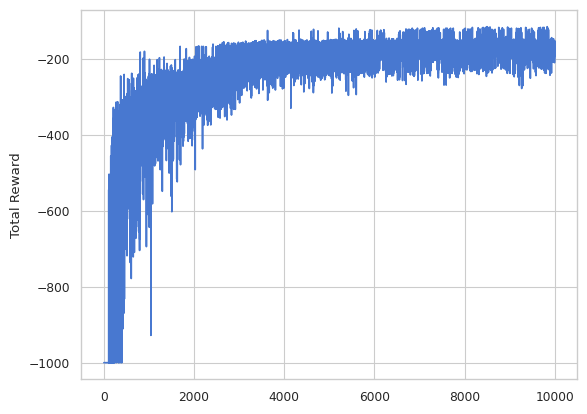

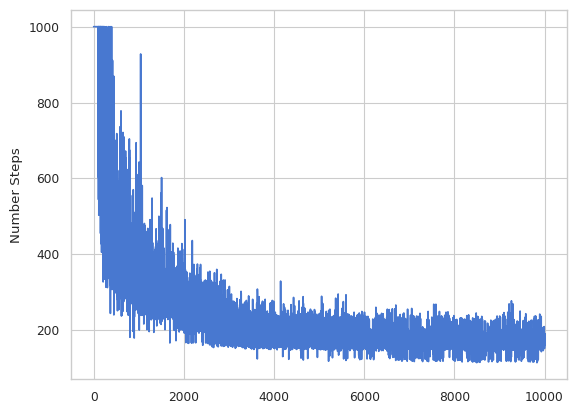

In [41]:
print(max(total_rewards))

plt.ylabel("Total Reward")
plt.plot(range(0,num_episodes),total_rewards)
plt.show()

plt.ylabel("Number Steps")
plt.plot(range(0,num_episodes),arr_steps)
plt.show()

Although, choosing a "stopping condition" to decide whether an agent learned navigating the environment can be somewhat arbitrary, we decide to take a visual approach. We consider an agent to be converging to a solution, when the trend line of the number of steps needed for reaching the flag is almost flat. 

This is the case in above graph, so we continue with our set-up and tune the hyperparameters to get to the best configuration.

#### 2.3 Hyperparameters
This section covers the hyperparameter tuning. We tried multiple grids until we reached a grid that we though was covering the best model performances (see screenshots below).

In [42]:
# Uncomment to run grid-search (takes super long)

# # Initialize dataframe for results
# results_df = pd.DataFrame(columns=["alpha", "gamma", "epsilon", "max_reward", "sd_reward"])

# # Hyperparameter loops
# for alpha in tqdm([0.6, 0.7], desc='Alpha'):
#     for gamma in [0.85, 0.9, 0.95]:
#         for epsilon in [0, 0.001, 0.025]:
#             print(f"Running Q-learning for alpha={alpha}, gamma={gamma}, epsilon={epsilon}")
#             q_table, total_rewards, steps = run_q_learning(env, alpha, gamma, epsilon, num_episodes, num_steps, position_batches, velocity_batches)
#             max_reward = max(total_rewards)
#             print(f"The maximum reward in this model configuration is: {max_reward}")

#             # Append results
#             results_df = pd.concat([results_df, pd.DataFrame({
#                 "alpha": [alpha],
#                 "gamma": [gamma],
#                 "epsilon": [epsilon],
#                 "max_reward": [max_reward],
#                 "sd_reward": [np.std(total_rewards)]
#             })], ignore_index=True)

# # Sort by max_reward
# results_df = results_df.sort_values(by=['max_reward'], ascending=False)

# display(results_df)

![Grid search results 1](../img1_grid-search.png)

![Grid search results 2](../img2_grid-search.png)

![Grid search results 3](../img3_grid-search.png)

![Grid search results 4](../img4_grid-search.png)

The best hyperparameter combination, using the maximum reward achieved would be (alpha=0.7, gamma=0.85, epsilon=0.025).

However, during hyperparameter tuning we realized that this followed some erratic behavior. The same configuration does not systematically produce the same results. Therefore, to not simply use the model that randomly performed best during our final run, we run each of the top 5 models 10 times and record the mean and sd. This was we can make sure to choose the best model on average.

In [ ]:
# Run top 5 models, 10 times each and record mean and sd of max reward

# Initialize dataframe for results
results_df = pd.DataFrame(columns=["alpha", "gamma", "epsilon", "avg_max_reward", "sd_max_reward", "median_max_reward"])

# Model params
model1 = [0.7, 0.85, 0.025]
model2 = [0.6, 0.85, 0.025]
model3 = [0.6, 0.85, 0]
model4 = [0.6, 0.95, 0.001]
model5 = [0.6, 0.85, 0.001]

models = [model1, model2, model3, model4, model5]

# Loop through models
for m in models:
    alpha = m[0]
    gamma = m[1]
    epsilon = m[2]

    print(f"Running Q-learning for alpha={alpha}, gamma={gamma}, epsilon={epsilon}")

    # Run model 10 times
    max_rewards = []

    for i in tqdm(range(10), desc='Runs'):
        q_table, total_rewards, steps = run_q_learning(env, alpha, gamma, epsilon, num_episodes, num_steps, position_batches, velocity_batches)
        max_rewards.append(max(total_rewards))

    # Append results
    results_df = pd.concat([results_df, pd.DataFrame({
        "alpha": [alpha],
        "gamma": [gamma],
        "epsilon": [epsilon],
        "avg_max_reward": [np.mean(max_rewards)],
        "sd_max_reward": [np.std(max_rewards)],
        "median_max_reward": [np.median(max_rewards)]
    })], ignore_index=True)

display(results_df)

Running Q-learning for alpha=0.7, gamma=0.85, epsilon=0.025


Runs: 100%|██████████| 10/10 [06:53<00:00, 41.32s/it]
/var/folders/rl/4rywqmwj3q57mkcp4qfpgcg80000gn/T/ipykernel_27360/373734997.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({


Running Q-learning for alpha=0.6, gamma=0.85, epsilon=0.025


Runs: 100%|██████████| 10/10 [07:06<00:00, 42.67s/it]


Running Q-learning for alpha=0.6, gamma=0.85, epsilon=0


Runs: 100%|██████████| 10/10 [07:05<00:00, 42.51s/it]


Running Q-learning for alpha=0.6, gamma=0.95, epsilon=0.001


Runs: 100%|██████████| 10/10 [07:05<00:00, 42.51s/it]


Running Q-learning for alpha=0.6, gamma=0.85, epsilon=0.001


Runs: 100%|██████████| 10/10 [07:04<00:00, 42.50s/it]


,alpha,gamma,epsilon,avg_max_reward,sd_max_reward,median_max_reward
0,0.7,0.85,0.025,-89.0,6.099180,-87.0
1,0.6,0.85,0.025,-89.3,6.067125,-87.5
2,0.6,0.85,0.000,-85.5,1.360147,-85.0
3,0.6,0.95,0.001,-89.6,2.690725,-88.5
4,0.6,0.85,0.001,-86.8,1.600000,-86.0


We decide to use the 3rd model in the list which produced not only the highest mean reward but also had the highest median, and the lowest SD. The low SD is likely related to the absence of epsilon in that model. The smaller epsilons seem to produce less divergent maximum rewards.

#### 2.4 Train the final agent

We now set the parameters as decided above. We also increase the number of episodes just to be even more sure about the convergence of our algorithm.

In [43]:
num_episodes = 12001
num_steps = 1000

In [44]:
# Implement q-learning with the best hyperparameters
best_alpha = 0.6
best_gamma = 0.85
best_epsilon = 0

q_table, total_rewards, steps = run_q_learning(env, best_alpha, best_gamma, best_epsilon, num_episodes, num_steps, position_batches, velocity_batches)

print(f"The maximum reward in this model configuration in this run is: {max(total_rewards)}")

The maximum reward in this model configuration in this run is: -85.0


-85.0


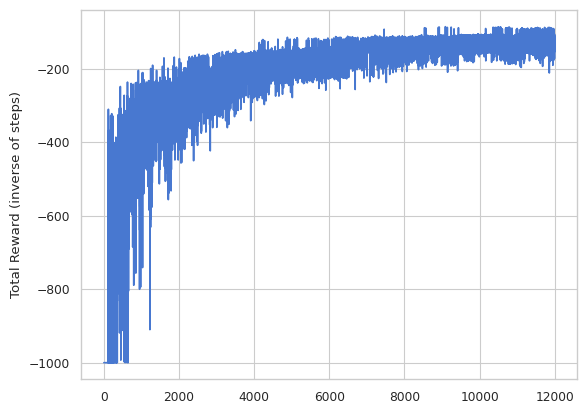

In [45]:
# Plot results
print(max(total_rewards))

plt.ylabel("Total Reward (inverse of steps)")
plt.plot(range(0,num_episodes),total_rewards)
plt.show()

Now, we extract the optimal policy to inspect it and compare to the deep learning agents further on in the notebook.

In [46]:
# Get the optimal policy
# print(q_table)
optimal_policy = np.zeros((P,V))
for pos in range(P):
    for vel in range(V):
        optimal_policy[pos,vel] = np.argmax(q_table[pos, vel, :])

print(optimal_policy.shape)
print(optimal_policy)

(100, 100)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


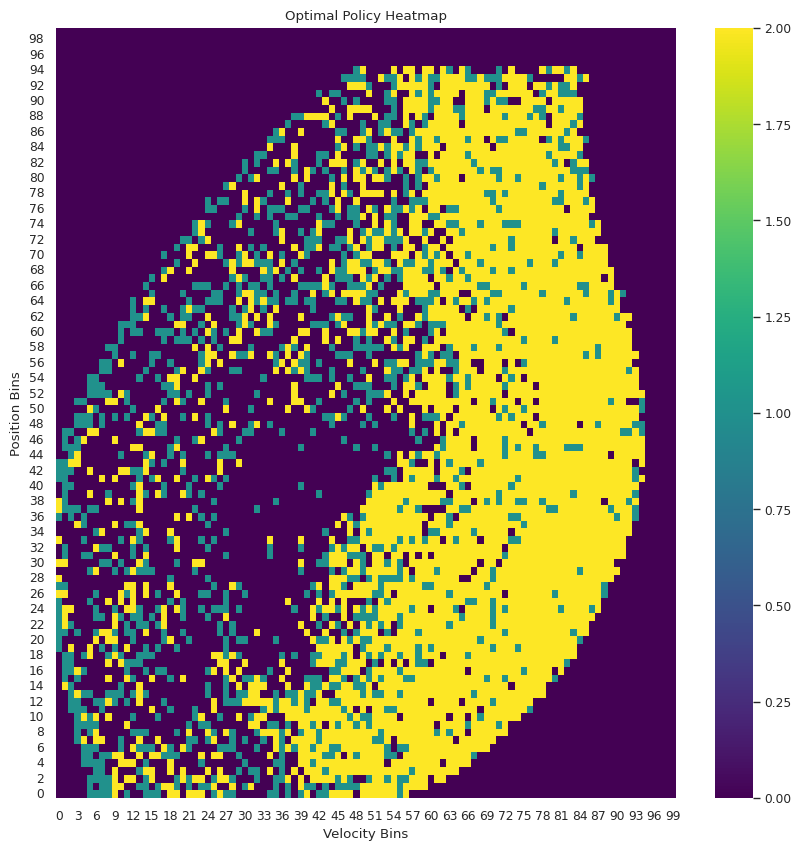

In [47]:
# Create the heatmap
plt.figure(figsize=(10, 10))  # Adjust the size as needed
ax = sns.heatmap(optimal_policy, cmap="viridis")

# Add titles and labels as needed
plt.title("Optimal Policy Heatmap")
plt.xlabel("Velocity Bins")
plt.ylabel("Position Bins")

# Flip the y-axis
ax.invert_yaxis()

# Show the plot
plt.show()

This heatmap displays the optimal policy at each discrete state. 

Although it is not very intuitive to read, we keep it here because it looks kinda beautiful. It could be considered RL art - "The Lemon in the Mountain Car Problem".

## 3. Deep-Q Learning

- Following the [TensorFlow tutorial](https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial?hl=en#introduction), but adapting to the Mountain-Car problem

### 3.1 Experiments
- Experiments done and their hyperparameters

| Number | Layers | Num Iterations | Learning Rate | Best Avg Return |
| ---- | ---- | ---- | ---- | ---- |
| 1 | (100,50) | 20.000 | 0.001 | -125 |
| 2 | (100,50) | 150.000 | 0.001 | -94 |
| 3 | (100,50) | 150.000 | 0.001 | -96 |
| 4 | (50,25) | 30.000 | 0.001 | -176 |
| 5 | (100,50,25) | 30.000 | 0.001 | -180 |
| 6 | (100,50,5) | 30.000 | 0.001 | -132 |
| 7 | (150,100) | 50.000 | 0.001 | -111 |
| 8 | (200,125,50) | 50.000 | 0.001 | -103 |
| 9 | (200,125,50) | 50.000 | 0.002 | -121 |
| 10 | (200,125,50) | 150.000 | 0.005 | -189 |
| 11 | (50,100,100,50) | 150.000 | 0.001 | -146 |
| 12 | (300,175,100) | 150.000 | 0.001 | -199 |

### 3.2 Analysis

It is possible to deduce some things from the results above:
- If the network is too small, the agent tends to underperform, which could mean that the network is not good enough/doesn't learn enough to perform well
- The same happens when network starts to get overcomplex, with more than 2 layers and above 150 neurons per layer. This might happen due to an overcomplicated network
- The "sweetspot" for network size appears to be around 2 layers, the first one having 100 neurons and the second one having 50. (this excluding the output layer,  which always has 3 neurons, 1 for each possible action in the action space)

These results are pretty good, if we have in account that the return is the result of subtracting "-1" for each step, meaning it only took 94 steps to reach the objective.

# 3.3 Comparing with the Q-Learn Agent
For this specific environment and problem, the Q-Learn Agent performs better than the Deep Q-Learn Agent and takes less iterations to reach a good result, even if the difference is subtle (+9 in terms of return).

This can be explained by the fact that the problem is somewhat simple. The action space only has 3 possibilities, which is an objectively low number.
If the problem was more complex, i.e., a larger or continuous action space and a bigger environment, it is highly probably that the Q-Learn Agent would struggle or even not be suitable to solve the problem (Q-Learn does not work in
continuous observation and action spaces)

Another explanation for these results can come from the fact that there are infinite possibilities for the network structure, and the tests we've done are limited given the computational power needed to run them. Thus, we could be missing the "special one" network that really would shine in this problem.


Creating a display for the visuals

In [ ]:
#
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()


### Hyperparameters
Definition of hyperparameters:
- layer params is refering to each layer's number of perceptrons
- num_iterations is the number of iterations to train the network
- batch_size is used for buffering the dataset
- num_episodes is the number of runs that we do to evaluate the network at some certain timestamps in the training
- the rest of the variables are mostly related with debugs or buffer/iterator

In [ ]:
dqn_layer_params = (100, 50) #

num_iterations = 150000

initial_collect_steps = 100
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000

batch_size = 64
learning_rate = 1e-3
log_interval = 250

num_episodes = 10
eval_interval = 750

### Env
Loading the environment from the gymnasium library

In [ ]:
env_name = "MountainCar-v0"
env_dqn = suite_gym.load(env_name)
env_dqn.reset()

TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([-0.5962081,  0.       ], dtype=float32)})

Visualize one starting point of the environment

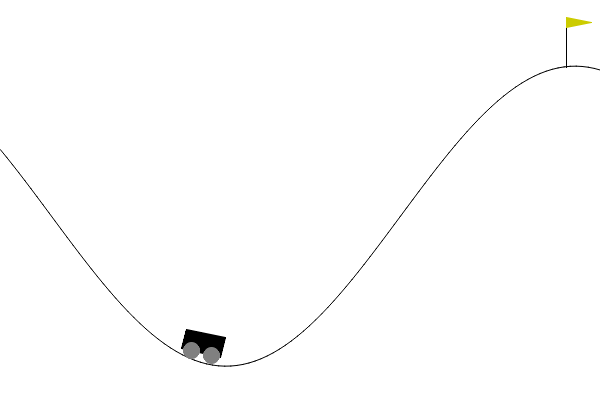

In [ ]:
PIL.Image.fromarray(env_dqn.render())

Understand the observation and action space's
In this environment, and as explained before in the Q-Learning, the action space has 3 possibilities:
- 0: Accelerate to the left
- 1: Don’t accelerate
- 2: Accelerate to the right

In [ ]:
print('Observation Space:')
print(env_dqn.time_step_spec().observation)

print('Action Space:')
print(env_dqn.action_spec())


Observation Space:
BoundedArraySpec(shape=(2,), dtype=dtype('float32'), name='observation', minimum=[-1.2  -0.07], maximum=[0.6  0.07])
Action Space:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=2)


### Environments
- written in python, need to be converted to tensorflow environments because of the matrix/tensor manipulations

In [ ]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [ ]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

### Agents

#### Layer Funcs
- Function that created a dense layer given the number of units in that layer

In [ ]:
def dense_layer(num_units, name= ""):
    return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      name=name
      ,kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal')
      )

- Creating all the layers given the hyperparameters

In [ ]:
action_tensor_spec = tensor_spec.from_spec(env_dqn.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# hidden layers
dense_layers = [dense_layer(num_unit, f"Layer_{i}") for num_unit,i in zip(dqn_layer_params, range(len(dqn_layer_params)))]

# last layer, with results
q_value_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    name = "q_layer"
    ,kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2)
    )

q_net = sequential.Sequential(dense_layers + [q_value_layer])

### Creating an Agent
- Initializing an agent with the environment spaces, as well as with the network and optimizer

In [ ]:
# choosing an optimizer, inputing the learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# step counter
train_step_counter = tf.Variable(0)

# create the agent object, feeding it with
# observation and action space,
# the network architecture,
# the choosen optimizer and a loss function
agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()


### Policies
- Initialize a random policy in order to create a baseline model for comparison

In [ ]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())


### Buffer
Creating a buffer to keep track of data collected from the environment.

[Documentation](https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial?hl=en#replay_buffer)

In [ ]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)


### Training the agent
- Defining a function to evaluate the network:
  - It runs the agent through the environment an arbitrary number of episodes and averages the results of the return given.

In [ ]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  total_steps = 0

  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0
    episode_steps = 0

    while not time_step.is_last():
      episode_steps += 1

      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward

    total_return += episode_return
    total_steps += episode_steps

  avg_return = total_return / num_episodes
  avg_steps = total_steps / num_episodes


  return avg_return.numpy()[0], avg_steps


In [ ]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)


In [ ]:
iterator = iter(dataset)

In [ ]:
# Baseline Performance with a random policy for a DQN-Agent
compute_avg_return(eval_env, random_policy, num_episodes)

(-200.0, 200.0)

In [ ]:
# Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return , avg_steps= compute_avg_return(eval_env, agent.policy, num_episodes)
returns = [avg_return]
steps = [avg_steps]
losses = []

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env_dqn,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  losses.append(train_loss)
  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return, avg_steps = compute_avg_return(eval_env, agent.policy, num_episodes)
    print('step = {0}: Average Return = {1}, Average Steps {2}'.format(step, avg_return, avg_steps))
    returns.append(avg_return)
    steps.append(avg_steps)


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 250: loss = 1.7225453853607178
step = 500: loss = 122.63923645019531
step = 750: loss = 1.2419350147247314
step = 750: Average Return = -200.0, Average Steps 200.0
step = 1000: loss = 1.071760654449463
step = 1250: loss = 1.70547616481781
step = 1500: loss = 187.49114990234375
step = 1500: Average Return = -200.0, Average Steps 200.0
step = 1750: loss = 18.312244415283203
step = 2000: loss = 0.478985995054245
step = 2250: loss = 86.04297637939453
step = 2250: Average Return = -200.0, Average Steps 200.0
step = 2500: loss = 1.0774004459381104
step = 2750: loss = 0.9972959756851196
step = 3000: loss = 179.70486450195312
step = 3000: Average Return = -200.0, Average Steps 200.0
step = 3250: loss = 1.2289483547210693
step = 3500: loss = 1.2646515369415283
step = 3750: loss = 0.7230914831161499
step = 3750: Average Return = -200.0, Average Steps 200.0
step = 4000: loss = 1.1426916122436523
step = 4250: loss = 114.13604736328125
step = 4500: loss = 163.06861877441406
step = 4500: Aver

### Plots

Best Avg Return: -101.9000015258789
Best Avg Steps: 101.9


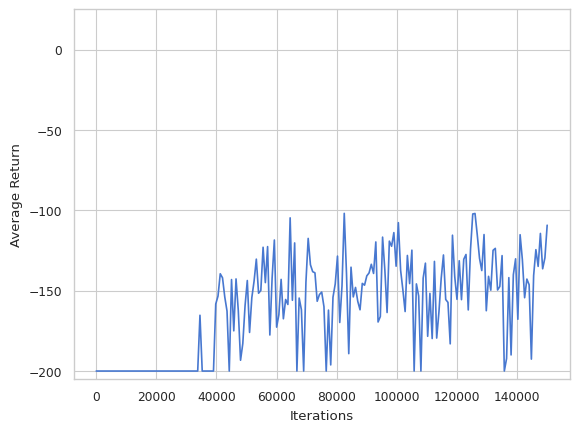

Text(0.5, 0, 'Iterations')

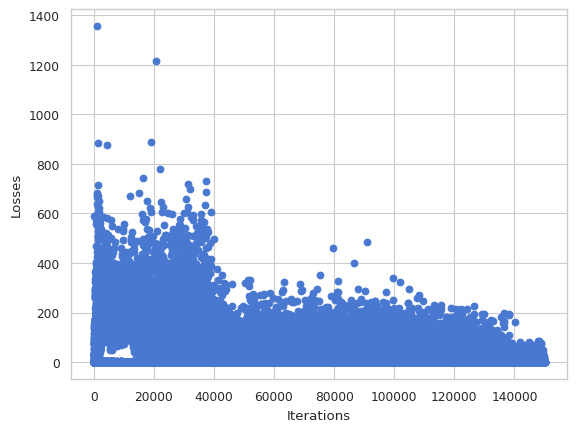

In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)

print(f"Best Avg Return: {max(returns)}")
print(f"Best Avg Steps: {min(steps)}")
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=25)
plt.show()

iterations_log = range(0, num_iterations)
plt.scatter(iterations_log, losses)
plt.ylabel('Losses')
plt.xlabel('Iterations')

The return is never worse than -200 because the environment is, by default, limited to 200 steps, in order to make it harder.
However, after some iterations, we can see that it starts to get a better average return, as well as lower loss.

### Videos

In [48]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)


In [49]:
def create_policy_eval_video_qlearn(filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):

      video.append_data(env.render())

      #initialize the state by resetting the environment
      s,_ = env.reset()
      total_reward = 0
      steps = 0

      # discretize
      s = [get_index_position_batch(s[0], position_batches), get_index_velocity_batch(s[1], velocity_batches)]

      #for each step in the episode
      for t in range(num_steps):

          #select the action using optimal policy table
          a = int(optimal_policy[s[0], s[1]])

          #perform the selected action and store the next state information
          s_, _ , done, _, _ = env.step(a)

          # discretize
          s_ = [get_index_position_batch(s_[0], position_batches), get_index_velocity_batch(s_[1], velocity_batches)]

          #update current state to next state
          s = s_

          video.append_data(env.render())

          #if the current state is the terminal state then break
          if done:
              break


  return embed_mp4(filename)

In [ ]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

In [ ]:
create_policy_eval_video(agent.policy, "trained-dqn-agent")

In [50]:
create_policy_eval_video_qlearn("trained-qlearn-agent")

In [ ]:
create_policy_eval_video(random_policy, "random-dqn-agent")


The videos clearly show that both trained agents perform substantially better than a random agent. 

Furthermore, we think that the difference between the DeepQ agent and the agent from the discretized q-table approach are not much different from each other. However, it seems like the DeepQ agent has las variability in the solutions as the basic q-table agent still displays one approach needing considerably more time than the others. 

To conclude, this project has shown that simpler algorithms can perform similarly well as more complex ones (especially in simpler problems), and it could be worthwhile to try them. 